<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(cw_attack_art.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Carlini and Wagner Attack using ART  

### Lab Objectives:  
- Build on the knowledge we got from the previous lab **cw_attack_manual.ipynb** where we implemented the C&W attack manually    
- Use Adversarial Robustness Toolkit to simplify the the solution   


### Step 1:  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models

import art
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import CarliniL2Method

import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchvision version used:  {torchvision.__version__}')
print(f'ART version used:  {art.__version__}')
print(f'Numpy version used:  {np.__version__}')

Torch version used:  2.7.1+cu128
Torchvision version used:  0.22.1+cu128
ART version used:  1.20.1
Numpy version used:  2.1.3


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


Rather than building our own model, we take a pre-trained model and target it instead. The pre-trained model we target will be the resnet50 model: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html  

In [4]:
# Load a pretrained resnet model and set it to eval mode
print(f'[*] Loading model ...')
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval() 
print('[*] Model switched to eval mode')

[*] Loading model ...
[*] Model switched to eval mode


When the model was trained, the images consisted of three channels. Each of these channels were also standardize with a mean and standard deviation. Hence, when passing new images into this model, we should make every effort to satisfy this criteria. This standardizing process took each data point, subtracted it from the mean of the channel and divided it by the standard deviation of the channel. i.e. 
    
               x - mean    
    std_x = -------------    
                 std    

Additionally, if the input image is larger or smaller than 256x256 pixels, we will resize it to ensure the size going into the model is 256x256.  We also Want to center crop the image. Basically it is cropping the image at the center and finally, we ensure the image is a converted to a torch tensor.  

### Step 2:   

In [5]:
# Setup a transform to preprocess the input image
# The model has been trained on preprocessed data
# We need to ensure that the data provided at prediction time is preprocessed the same way

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Similarly to how we normalize the input for the model, we want to unnormalize the data. This is especially needed for visualization of the model's output. 

This is what we had for standardization   
               x - mean    
    std_x = -------------    
                 std  


We can now move things around and get back to the unnormalize data.   Our formula for unnormalizing would look like:   
std_x * std = x - mean   
This is then equal to   
std_x * std + mean = x  
or putting it another way   
x_orig = std_x * std + mean   

Obviously the algorithm is going to use some neat little tricks to solve this problem. However, this concept still applies   


### Step 3:   

In [6]:
# Inverse of the normalization
# This is needed for visualization of the adversarial example
# Why use these values
inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


In [7]:
# Define a URL variable
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_Retriever_Dukedestiny01_drvd.jpg/500px-Golden_Retriever_Dukedestiny01_drvd.jpg'
response = requests.get(url=url)
if response.status_code == 200:
    print(f'[*] Successfully retrieved file. URL is valid')
    print(response.content)
else:
    print(f'[!] Unable to retrieve file. Please verify the URL: {url} is valid: {response.status_code} ')

[*] Successfully retrieved file. URL is valid
b'\xff\xd8\xff\xdb\x00C\x00\x04\x03\x03\x04\x03\x03\x04\x04\x03\x04\x05\x04\x04\x05\x06\n\x07\x06\x06\x06\x06\r\t\n\x08\n\x0f\r\x10\x10\x0f\r\x0f\x0e\x11\x13\x18\x14\x11\x12\x17\x12\x0e\x0f\x15\x1c\x15\x17\x19\x19\x1b\x1b\x1b\x10\x14\x1d\x1f\x1d\x1a\x1f\x18\x1a\x1b\x1a\xff\xdb\x00C\x01\x04\x05\x05\x06\x05\x06\x0c\x07\x07\x0c\x1a\x11\x0f\x11\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\xff\xc0\x00\x11\x08\x01\x8b\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x06\x03\x04\x02\x07\x08\x00\x01\xff\xc4\x00B\x10\x00\x02\x02\x01\x03\x03\x03\x02\x04\x05\x02\x05\x03\x03\x02\x07\x01\x02\x03\x04\x11\x05\x12!\x00\x061\x13"A\x14Q\x072aq\x15#B\x81\x91R\xa1$3b\xb1\xc1\x16\xd1\xf0r\xe1\xf1\x08%C\x82S\x92\xa2&4\xff\xc4\x

If for some reason the above fails, this file is also in the data folder. Here are some steps to take:  
- Open a terminal/shell/command prompt   
- Go to the data folder. eg. cd ..
- My data folder looks like: ../data/Golden_Retriever_Dukedestiny01_drvd.jpg
- Once in this folder load up a python webserver by doing 
- $ python -m http.server 8080
- You should see: Serving HTTP on 0.0.0.0 port 8080 (http://0.0.0.0:8080/) ... 

With this in place you can uncomment below and get the file  

In [8]:
# Define a URL variable
#url = 'http://127.0.0.1:8080/Golden_Retriever_Dukedestiny01_drvd.jpg'

#if response.status_code == 200:
#    print(f'[*] Successfully retrieved file. URL is valid')
#    print(response.content)
#else:
#    print(f'[!] Unable to retrieve file. Please verify the URL: {url} is valid: {response.status_code} ')
#    print('[*] Please uncomment and run the cell below: ')

Alternatively, if you don't have patience for any of above, simply read the file instead. 

In [9]:
# Alternative for the image of the dog
# Only uncomment if above fails or return a status code other than 200

#img = Image.open(fp='graphics/Golden_Retriever_Dukedestiny01_drvd.jpg')
#plt.imshow(img)
#plt.axis('off')
#img_transformed = transform(img=img).unsqueeze(dim=0)
#img_transformed

Let us also get the labels to work with. 

### Step 5

In [10]:
# Get all the labels. Just a reference point
resnet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
resnet_labels = requests.get(url=resnet_labels_url).json()
print(resnet_labels[:5])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


If above fails, then grab the content locally by uncomment the lines below.   

You might be wondering why I did not just let you read the file system and get the file. The reality is, we need to know how to work with data that is coming from multiple sources. This is a good example for us to get enough practice.  

In [11]:
# Get the labels via backup method if the original fail
# Uncomment below if you encounter errors with the request
# Only if a response other than 200 is returned
#with open(file='resnet_labels.txt', mode='rt') as fp:
#    resnet_labels = fp.read().replace('"', '').split('\n')

#print(resnet_labels[:5])


In [12]:
# Rather than a list, let's make this into a dictionary
resnet_labels = { key:value for key,value in enumerate(resnet_labels, start=0)}
resnet_labels

{0: 'tench',
 1: 'goldfish',
 2: 'great white shark',
 3: 'tiger shark',
 4: 'hammerhead shark',
 5: 'electric ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house finch',
 13: 'junco',
 14: 'indigo bunting',
 15: 'American robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'American dipper',
 21: 'kite',
 22: 'bald eagle',
 23: 'vulture',
 24: 'great grey owl',
 25: 'fire salamander',
 26: 'smooth newt',
 27: 'newt',
 28: 'spotted salamander',
 29: 'axolotl',
 30: 'American bullfrog',
 31: 'tree frog',
 32: 'tailed frog',
 33: 'loggerhead sea turtle',
 34: 'leatherback sea turtle',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle',
 38: 'banded gecko',
 39: 'green iguana',
 40: 'Carolina anole',
 41: 'desert grassland whiptail lizard',
 42: 'agama',
 43: 'frilled-necked lizard',
 44: 'alligator lizard',
 45: 'Gila monster',
 46: 'European green lizard',
 47: 'chameleon',
 48: 'Komodo dragon',
 49: 'Nile c

Let us now create a function to simplify some of this problem for us going forward, with taking an image and converting it to a tensor.   

### Step 6:  

In [13]:
# Get an image from a URL and transform it to a tensor
def get_image_from_url(image_url=None, show_image=False):
    response = requests.get(url=image_url)
    img = Image.open(fp=BytesIO(initial_bytes=response.content)).convert('RGB')
    
    if show_image:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    img_transformed = transform(img)
    # Add a batch dimension to the image. Input to the network needs to be (-1, 3, 224, 224)
    img_transformed = img_transformed.unsqueeze(dim=0)

    # Return the transformed tensor
    return img_transformed


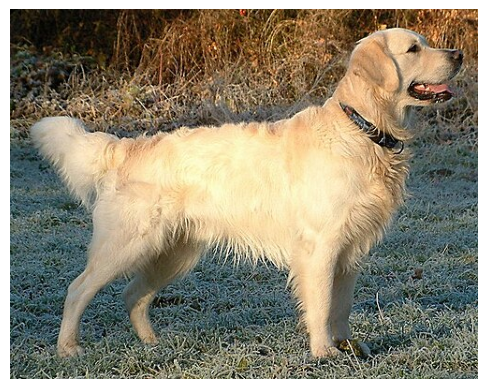

array([207])

In [14]:
# Get the image and make a prediction with the model
original_X = get_image_from_url(image_url=url, show_image=True)

# At the same time, convert the label to numpy array
original_label = model(original_X).max(dim=-1)[1].numpy()
original_label

In [15]:
# Currently the function outputs a torch tensor
# For ART, this needs to be a numpy array
original_X = original_X.detach().numpy()
original_X.shape, type(original_X)

((1, 3, 224, 224), numpy.ndarray)

Let us now prepare to setup our art attack.  
We will need an optimizer and our loss function...

### Step 7:  

In [16]:
# Define an optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Ad a loss function
loss_fn = nn.CrossEntropyLoss()

Setup the ART classifier based on our model

### Step 8:   

In [17]:
# Create the ART Pytorch Classifier Wrapper   
art_classifier = PyTorchClassifier(
    model=model,    # The model we are targeting 
    loss=loss_fn,   # Our loss function 
    input_shape=original_X.shape[1:],  # THe shape of our input without the batch dimension 
    nb_classes=len(resnet_labels), # Number of classes to predict
    optimizer=optimizer, 
    clip_values=(0., 1.),    # Clip the values between 0 and 1
    device_type=device,
    
    )

In [18]:
# Make a prediction on the original input with the art classifier
art_original_Z = art_classifier.predict(original_X)

# Get the label from the prediction.  
art_original_label = np.argmax(a=art_original_Z, axis=-1)

print(f'Original label: {art_original_label}')

# Verify that the original label and the predicted label are the same
assert original_label == art_original_label, f"Error original label: {original_label} != art predicted label: {art_original_label}"

Original label: [207]


In [19]:
# Set the target label at two like was done before

# We know the attack works so far based on our testing.
# Let's now prepare to finalize this
# What target label do we want to flag this as
# Remember, we can look at the resent labels via
resnet_labels

# For simplicity, let's try to make this a Great White Shark wich is at index 2
# you can play around with other labels
tgt_label = np.array([2])
resnet_labels.get(tgt_label.item(), 'Unknown Label Specified')

'great white shark'

The target vector for our labels has to be one hot encoded. As a result, we create a vector of all zeros and at the index position of our target label, we put a a one.  

### Step 9:  

In [20]:
# Like was done in the attack we created above, ART expects the label to be in a one hot encoded format
tgt_one_hot = np.zeros(shape=(1, len(resnet_labels)))

# Assign the index of the class we would like the model to predict
tgt_one_hot[0, tgt_label] = 1

# Take a peak into the data. We see the index 2 is now set
tgt_one_hot[0, :5]

array([0., 0., 1., 0., 0.])

With the targets in place and the classifier setup. we can now move on to setting up our attack.  

### Step 10:  

In [21]:
# Kicking off the attack
# Larger numbers are better for the max_iter and binary_search_steps. 
# However, you do have to have patience ....
cw_attack = CarliniL2Method(
    classifier=art_classifier, 
    confidence=0,   # Try setting this to 10 and initial_constant to 5 and see what happens
    targeted=True, 
    learning_rate=0.05, 
    max_iter=100,            # Ensure you have patience when setting this and binary_search_steps to larger numbers
    binary_search_steps=5,  # Increasing the amount of binary searches can make this better but take longer
    initial_const=5, 
    batch_size=1
    )

cw_attack

CarliniL2Method(confidence=0, targeted=True, learning_rate=0.05, max_iter=100, binary_search_steps=5, initial_const=5, max_halving=5, max_doubling=5, batch_size=1, verbose=True, )

Here is where we now generate the adversarial examples. Also because this is a targeted attack, we have the y=tgt_one-hot, which points to our one hot encoded vector. 

In [22]:
print(f'[*] Generating adversarial example via Carlini & Wagner attack ...')
adv_x = cw_attack.generate(x=original_X, y=tgt_one_hot)

[*] Generating adversarial example via Carlini & Wagner attack ...


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# How did the model do on the adversarial example
# Get the logits
adv_Z = art_classifier.predict(x=adv_x)

# Extract the label now from the logits
adv_pred_label = np.argmax(a=adv_Z, axis=-1)

adv_Z

f'SUCCESSFUL ATTACK target label: {tgt_label.item()} == predicted label: {adv_pred_label.item()}' if tgt_label == adv_pred_label else f'UNSUCCESSFUL ATTACK'

'SUCCESSFUL ATTACK target label: 2 == predicted label: 2'

In [24]:
# Get the distortion using the L2 norm 
l2_perturbation = np.linalg.norm( original_X - adv_x)
print(f'The L2 perturbation norm is: {l2_perturbation:.4f}')

The L2 perturbation norm is: 273.7042


As always, we want to visualize the attack.  

### Step 11:  

In [25]:
# Denormalize the original input and at the same time, remove the batch dimension via squeeze
# The shape at this point would be 4 dimensions. We need at 3 so we remove the batch dimension
print(f'Shape or original_X is: {original_X.shape}')
original_X_denormalize = inverse_normalize(torch.tensor(original_X)).squeeze(dim=0)

print(f'Shape or original_X AFTER SQUEEZING is: {original_X_denormalize.shape}')

# One more change for visualization with matplotlib.
# We need the channels last
# So rather than torch.Size([3, 224, 224]) we need torch.Size([224, 224, 3])
# Hence we permute
original_X_denormalize = original_X_denormalize.permute(dims=(1,2,0))
print(f'Shape or original_X AFTER PERMUTING is: {original_X_denormalize.shape}')

Shape or original_X is: (1, 3, 224, 224)
Shape or original_X AFTER SQUEEZING is: torch.Size([3, 224, 224])
Shape or original_X AFTER PERMUTING is: torch.Size([224, 224, 3])


In [26]:
# We go through the same process for the adversarial example
# This time, let's fuse all the operations together
adv_x_denormalize = inverse_normalize(torch.tensor(adv_x).squeeze(dim=0)).permute(dims=(1,2,0))
adv_x_denormalize.shape


torch.Size([224, 224, 3])

In [27]:
# Let's get the perturbation and ensure we prepare it for display
# Fusing everything again like was done above
perturbation = adv_x[0] - original_X[0]
perturbation_for_display = inverse_normalize(torch.tensor(perturbation)).permute(dims=(1,2,0))
perturbation_for_display.shape

torch.Size([224, 224, 3])

<Figure size 1500x500 with 0 Axes>

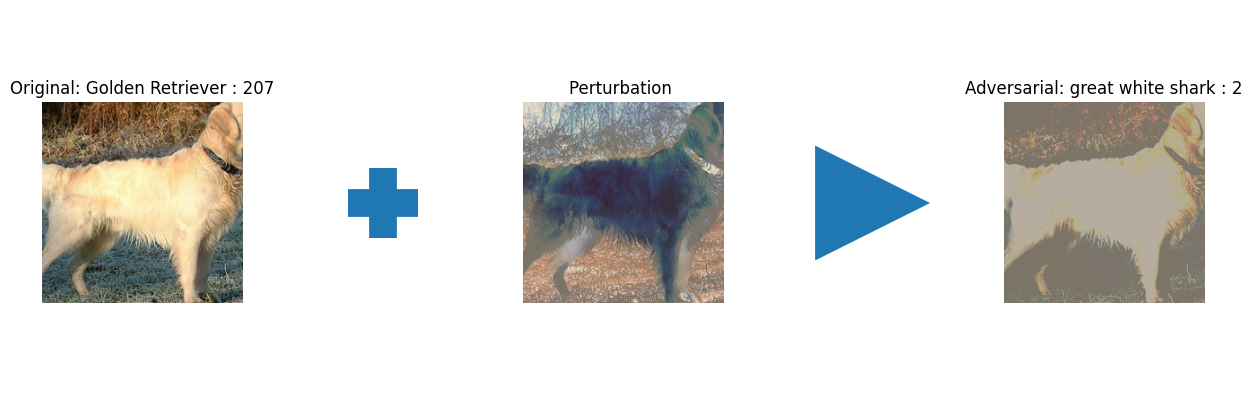

In [28]:
# Visualize, Visualize, Visualize
plt.figure(figsize=(15, 5))

# With everything in place, let's visualize 
plt.figure(figsize=(15, 5))
plt.subplot(1,5,1)
plt.title(label=f'Original: {resnet_labels.get(original_label.item(), "Unknown Label Specified")} : {original_label.item()}')
plt.imshow(X=original_X_denormalize)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.plot([5], marker='+', markersize=50, mew=20)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title(label=f'Perturbation ')
plt.imshow(X=perturbation_for_display)
plt.axis('off')

plt.subplot(1, 5, 4)
plt.plot([5], marker='>', markersize=50, mew=20)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title(label=f'Adversarial: {resnet_labels.get(tgt_label.item(), "Unknown Label Specified")} : {tgt_label.item()}')
plt.imshow(X=adv_x_denormalize)
plt.axis('off')

plt.show()

Ok, that's it for the C&W attack

### Lab Takeaways:   
- We now have a solid understanding of how to perform the C#W attack   
- We leverage the ART framework to simplify this task   
- We were able to visualize our perturbations 
- We saw that the perturbation can result in the image changing class  